# Test projections

In [50]:
import tifffile
from src import get_device, _PATH_DATA
from src.dataloaders import CTDataModule
import numpy as np
from tqdm import tqdm
import scipy
import torch
import matplotlib.pyplot as plt

# Args dict used to organise the arguments
args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/synthetic_fibers_plenoptic/fiber_00',
        "seed":42,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 10,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":300,
        "imagefit_mode":False,
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'relu',
    },
}

def compute_projection_values(num_points,attenuation_values):
    I0 = 1
    # Compute the spacing between ray points
    dx = 2 / (num_points)

    # Compute the sum of mu * dx along each ray
    attenuation_sum = torch.sum(attenuation_values * dx, dim=1)

    # Compute the intensity at the detector using the Beer-Lambert Law
    intensity = I0 * torch.exp(-attenuation_sum)
    
    # Inverse the intensity to make it look like CT
    return I0-intensity

In [2]:
datamodule = CTDataModule(args_dict)
datamodule.setup("fit")

Generating points from rays: 100%|██████████| 16/16 [00:12<00:00,  1.28it/s]


  0%|          | 0/16 [00:00<?, ?it/s]

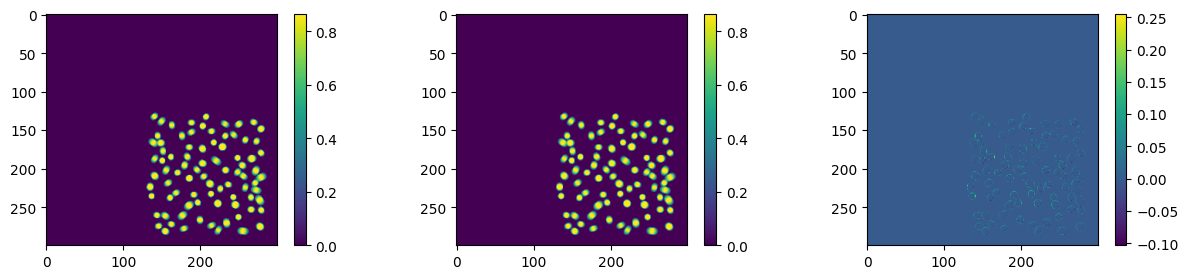

  6%|▋         | 1/16 [00:13<03:15, 13.03s/it]

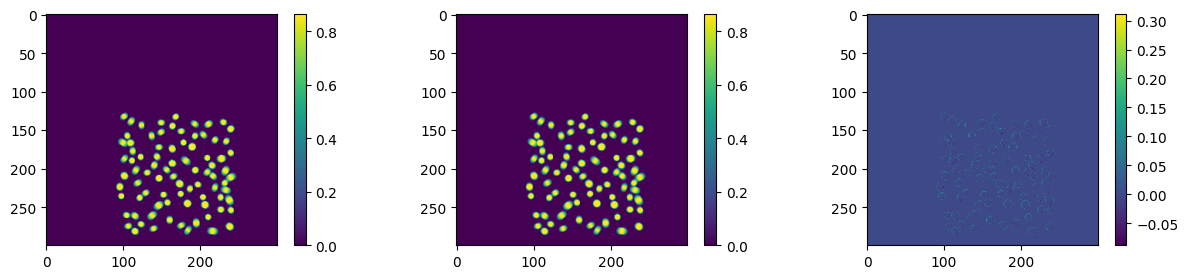

 12%|█▎        | 2/16 [00:25<02:53, 12.43s/it]

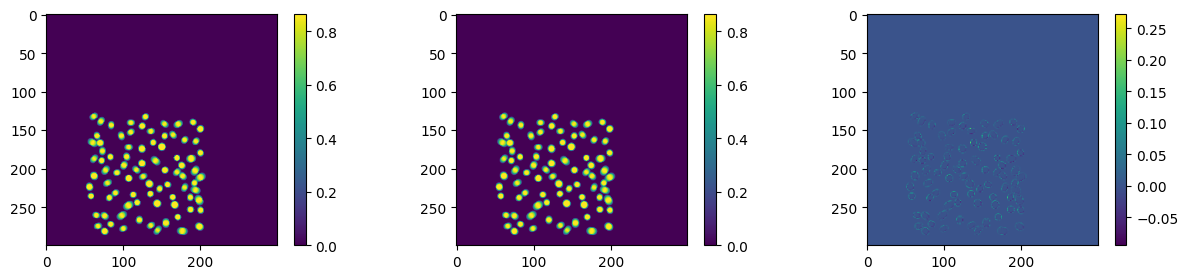

 19%|█▉        | 3/16 [00:37<02:38, 12.22s/it]

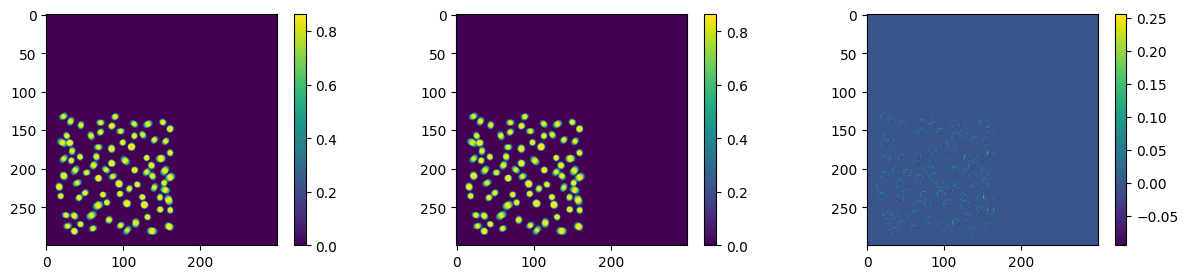

 25%|██▌       | 4/16 [00:49<02:26, 12.17s/it]

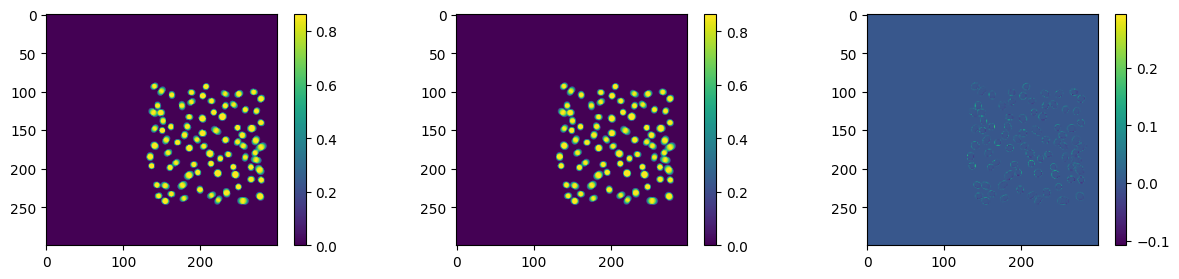

 31%|███▏      | 5/16 [01:00<02:12, 12.07s/it]

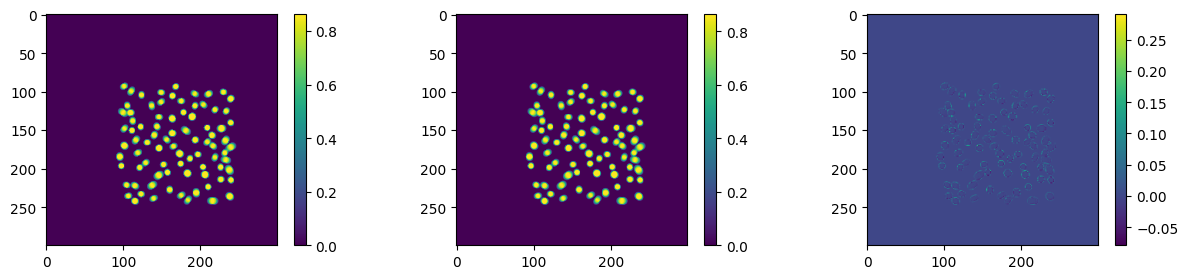

 38%|███▊      | 6/16 [01:12<02:00, 12.03s/it]

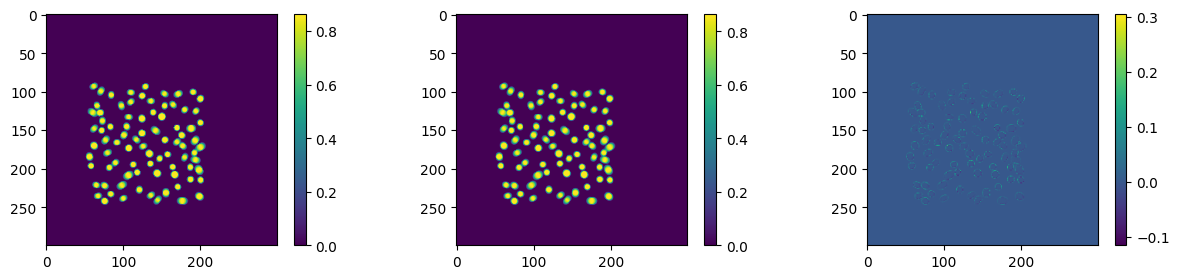

 44%|████▍     | 7/16 [01:24<01:48, 12.00s/it]

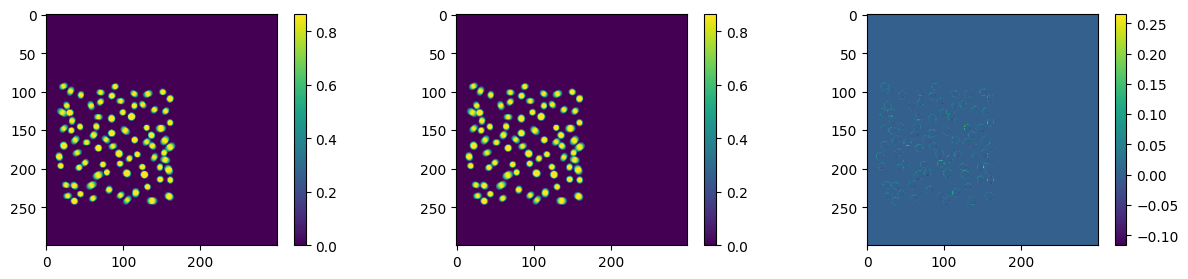

 50%|█████     | 8/16 [01:36<01:35, 11.99s/it]

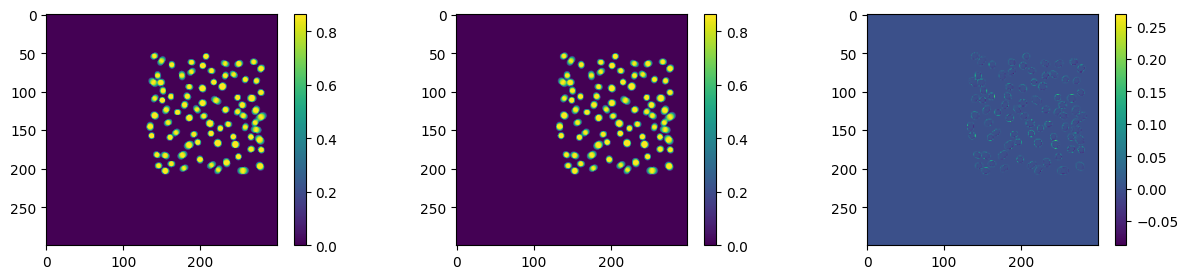

 56%|█████▋    | 9/16 [01:48<01:24, 12.03s/it]

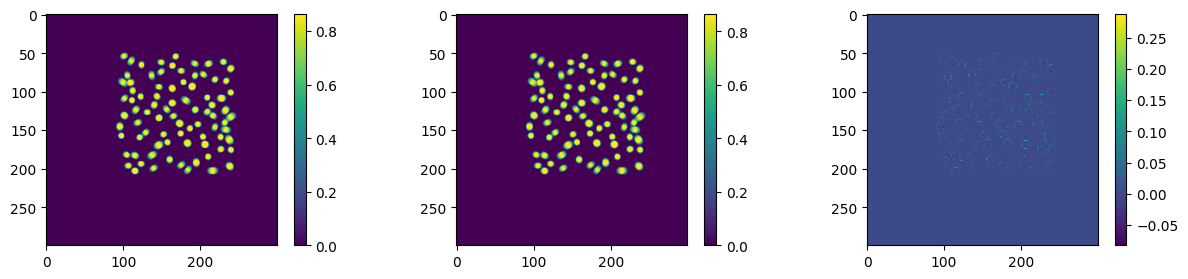

 62%|██████▎   | 10/16 [02:00<01:12, 12.02s/it]

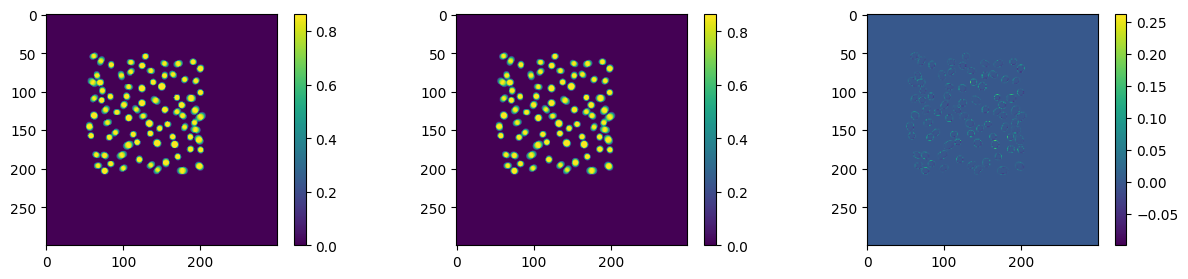

 69%|██████▉   | 11/16 [02:13<01:00, 12.02s/it]

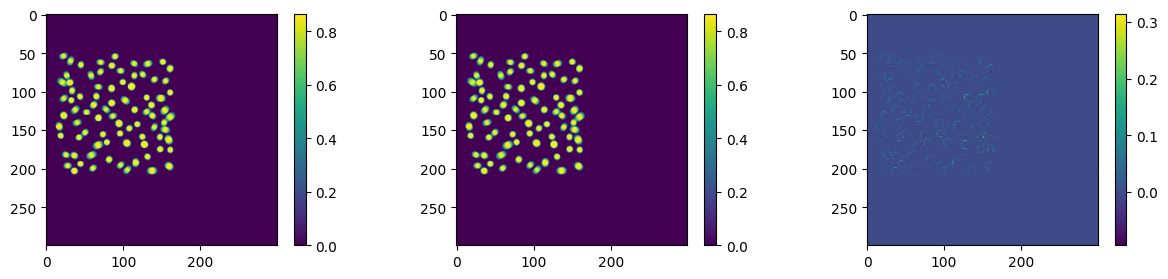

 75%|███████▌  | 12/16 [02:24<00:47, 11.98s/it]

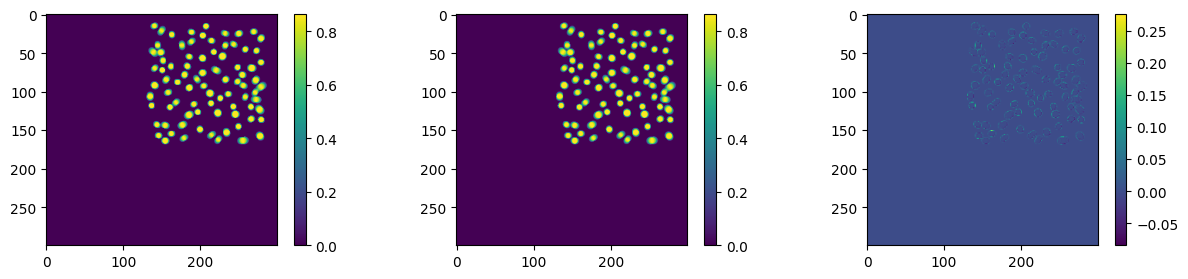

 81%|████████▏ | 13/16 [02:36<00:35, 11.95s/it]

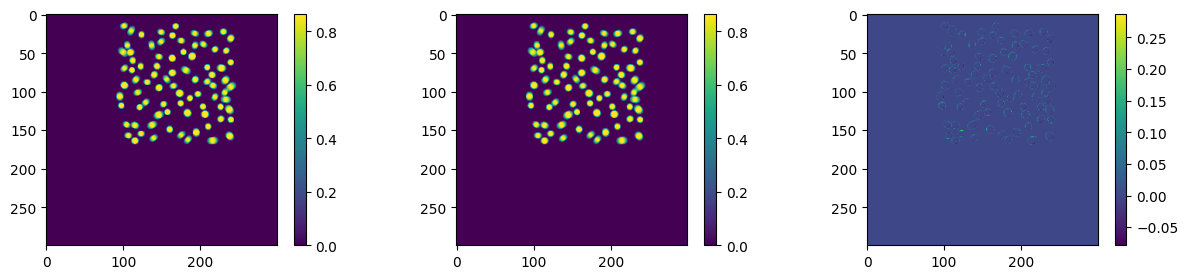

 88%|████████▊ | 14/16 [02:48<00:24, 12.02s/it]

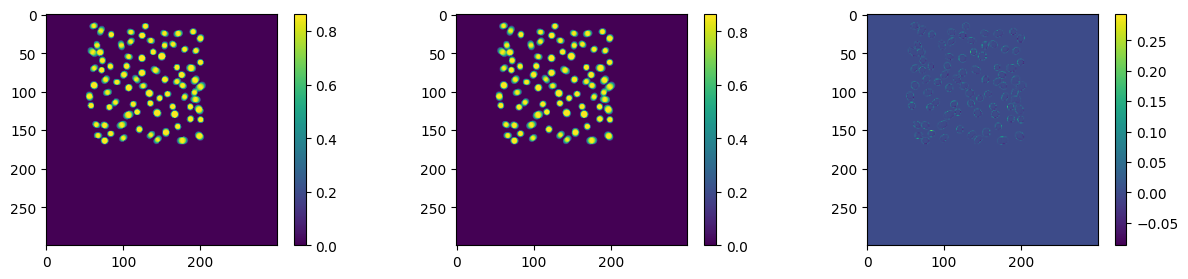

 94%|█████████▍| 15/16 [03:00<00:11, 12.00s/it]

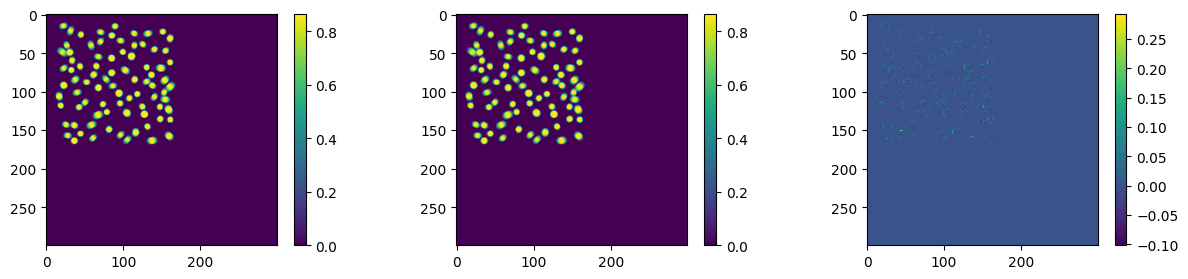

100%|██████████| 16/16 [03:12<00:00, 12.05s/it]


In [3]:
img = datamodule.dataset.img.numpy()

grid = (np.linspace(0, 299, 300),np.linspace(0, 299, 300),np.linspace(0, 299, 300))
for i in tqdm(range(16)):
    points = datamodule.dataset.geometries[i].points.numpy()
    attenuation_values = scipy.interpolate.interpn(grid,img,(points*150+150),bounds_error=False,fill_value=0)
    
    detector_value_hat = compute_projection_values(points.shape[1],torch.tensor(attenuation_values))
    detector_value_hat = detector_value_hat.view(300,300).numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 3))
    mine = ax[0].imshow(detector_value_hat)
    astra = ax[1].imshow(datamodule.dataset.projections[i,:,:])
    diff = ax[2].imshow(datamodule.dataset.projections[i,:,:]-detector_value_hat)
    fig.colorbar(mine,ax=ax[0])
    fig.colorbar(astra,ax=ax[1])
    fig.colorbar(diff,ax=ax[2])
    plt.show()

In [3]:
img = datamodule.dataset.img.numpy()

i = 1
grid = (np.linspace(0, 299, 300),np.linspace(0, 299, 300),np.linspace(0, 299, 300))
points = datamodule.dataset.geometries[i].points.numpy()
attenuation_values = scipy.interpolate.interpn(grid,img,(points*150+150),bounds_error=False,fill_value=0)

detector_value_hat = compute_projection_values(points.shape[1],torch.tensor(attenuation_values))
detector_value_hat = detector_value_hat.view(300,300).numpy()

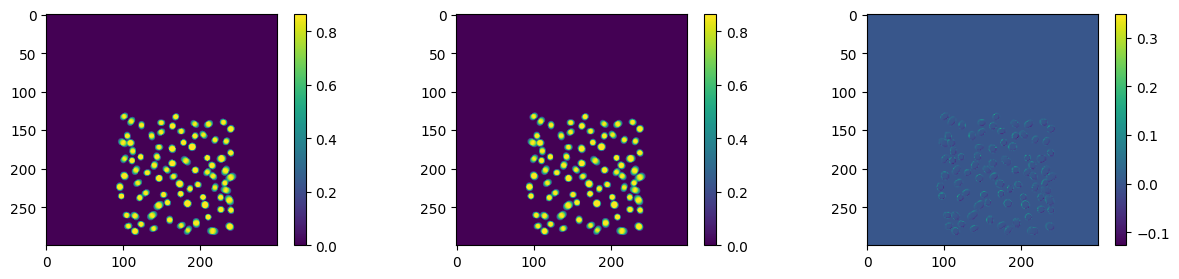

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
mine = ax[0].imshow(detector_value_hat)
astra = ax[1].imshow(datamodule.dataset.projections[i,:,:])
diff = ax[2].imshow(datamodule.dataset.projections[i,:,:]-detector_value_hat)
fig.colorbar(mine,ax=ax[0])
fig.colorbar(astra,ax=ax[1])
fig.colorbar(diff,ax=ax[2])
plt.show()

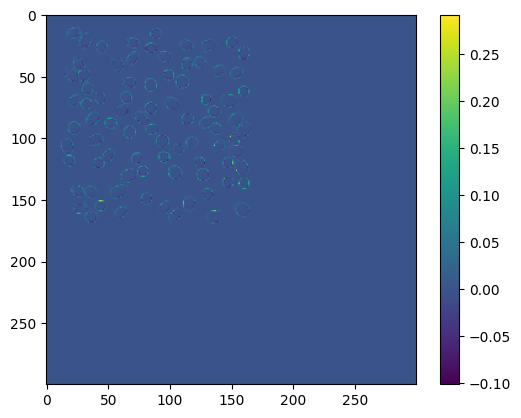

In [4]:
plt.imshow(datamodule.dataset.projections[i,:,:]-detector_value_hat)
plt.colorbar()

# Test trained model

In [1]:
import numpy as np
import tifffile
from tqdm import tqdm
import scipy.ndimage as ndi

import torch
import torch._dynamo

from src.dataloaders import CTDataModule
from src.models.mlp import MLP
from src import get_device, _PATH_DATA, _PATH_MODELS

args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/synthetic_fibers_angle/fiber_00',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 10,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":256,
        "imagefit_mode":False,
        "noisy_points":False,
        "regularization_weight":1e-1,
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'sine',
    },
}

In [2]:
# datamodule = CTDataModule(args_dict)
# datamodule.setup()
# loader = datamodule.dataloader_for_testing()

In [3]:
projection_shape = np.load(f"{args_dict['general']['data_path']}_projections.npy").shape
model = MLP(args_dict, 
            projection_shape=projection_shape[::2]
           ).to(args_dict['training']['device'])

checkpoint_path = f"{_PATH_MODELS}/synthetic_fibers_angle-2024-07-03-1305/MLP-epoch=69.ckpt"
model.load_state_dict(torch.load(checkpoint_path, map_location=None)['state_dict'], strict=True)
model.eval();
model.cuda();

/tmp/ipykernel_5084/1572469466.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=None)['state_dict'], strict

In [4]:
img = torch.tensor(tifffile.imread(f"{args_dict['general']['data_path']}.tif"))
img -= img.min()
img = img/img.max()
img = img.permute(2,1,0)
tifffile.imwrite("fiber_synthetic.tif",(img.numpy()*255).astype("uint8"))

In [5]:
mgrid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, img.shape[0]), torch.linspace(-1, 1, img.shape[1]), torch.linspace(-1, 1, img.shape[2]), indexing='ij'),dim=-1)
mgrid = mgrid.view(-1,img.shape[2],3)
outputs = torch.zeros((*mgrid.shape[:2],1))
for i in tqdm(range(mgrid.shape[1])):
    with torch.no_grad():
        output = model(mgrid[:,i,:].cuda())
    outputs[:,i,:] = output.cpu()

100%|██████████| 300/300 [00:04<00:00, 60.52it/s] 


In [6]:
outputs = outputs.view(img.shape)

In [9]:
outputs -= outputs.min()
outputs /= outputs.max()

In [10]:
tifffile.imwrite("fiber_synthetic_mlp.tif",(outputs.numpy()*255).astype("uint8"))

# Testing

In [14]:
import tifffile
from src import get_device, _PATH_DATA
from src.dataloaders import CTDataModule
import numpy as np
from tqdm import tqdm
import scipy
import torch
import matplotlib.pyplot as plt

# Args dict used to organise the arguments
args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/synthetic_fibers_plenoptic/fiber_00',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 10,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":256,
        "imagefit_mode":False,
        "noisy_points":False,
        "regularization_weight":1e-1,
        "noisy_data":True,
        "noise_std":1e-2,
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'relu',
    },
}

def compute_projection_values(num_points,attenuation_values):
    I0 = 1
    # Compute the spacing between ray points
    dx = 2 / (num_points)

    # Compute the sum of mu * dx along each ray
    attenuation_sum = torch.sum(attenuation_values * dx, dim=1)

    # Compute the intensity at the detector using the Beer-Lambert Law
    intensity = I0 * torch.exp(-attenuation_sum)
    
    # Inverse the intensity to make it look like CT
    return I0-intensity

In [2]:
# datamodule = CTDataModule(args_dict)
# datamodule.setup()
# loader = datamodule.train_dataloader()

Generating points from rays: 100%|██████████████████████████████████████████████████| 16/16 [00:10<00:00,  1.55it/s]


In [6]:
projections = np.load(f"{args_dict['general']['data_path']}_projections.npy")

In [15]:
noise = np.random.normal(loc=0,scale=args_dict['training']['noise_std'],size=projections.shape)

In [16]:
(projections + noise).max()

0.900300928791896

In [17]:
(projections + noise).min()

-0.04864656231242183

In [8]:
projections.max()

0.8637768

In [90]:
from glob import glob

In [100]:
file = f"{_PATH_DATA}/walnut_angle/walnut.tif"
tifffile.imwrite(file,np.swapaxes(tifffile.imread(file),0,2))

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [29]:
def lr_lambda(epoch: int):
    if epoch <= 10:
        return 1.0
    else:
        return 0.96 ** (epoch-10)

In [30]:
lr = []
for i in range(150):
    lr.append(lr_lambda(i)*1e-4)

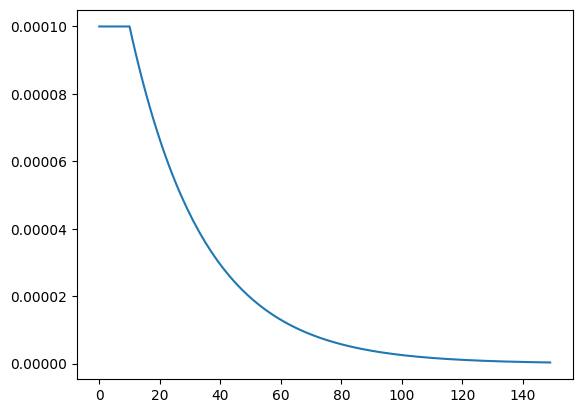

In [31]:
plt.plot(lr)

In [33]:
lr[50]

1.9536615155531993e-05